#Импорт библиотек

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

#Функции/Классы

In [22]:
def normalize_to_0_10(feature):
    """Нормализует данные в диапазон от 0 до 10."""
    min_val = np.min(feature)
    max_val = np.max(feature)
    normalized_feature = 10 * (feature - min_val) / (max_val - min_val)
    return normalized_feature


########################################################################################################


def super_train_test_split(df: pd.DataFrame, y: pd.Series):
    '''
    Делит данные на две выборки: 1. строки, значения необходимого нам столбца не имеют пропусков.
                                2. строки, значения необходимого нам столбца имеют пропуски.
    Каждый из этих пунктов так же делиться на две выборки: а) необходимый столбец.
                                                            б) остальные факторы.

    Аргументы:
        df: Pandas DataFrame, состоящий из факторов, инмеющих зависимость с признаком,
            в котором необходимо заполнить пропуски.

        y: Pandas Series, признак, пропуски которого необходимо заполнить.

    небольшой комментарий:
    У нас есть проблема - для заполенния пропусков с помощью какой-либо модели, необходимо,
    чтобы ВСЕ значения в других признаках были заполнены(не было пропусков).
    В противном случае модель ругается, что есть NaNы. Данный цикл устраняет данную проблему,
    временно заполняя пропуски в столбцах на медиану всех значений признака
    (кроме столбца, задача для которого изначально была заполнить пропуски с помощью модели).
    Дальше смотрите по комментариям
    '''
    X = df.copy()

    y_train = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X_train = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

    idxs = y_train.index # берём иднексы c изначально заполенными значениями
    X_test = X.drop(idxs) # отбрасываем строки с заполненными значениями в нужном нам столбце.
                        # Получается выборка с данными, на основе которых будут
                        # предсказываться пропущенные значения



    return X_train, X_test, y_train, y_temp


#####################################################################################################


def split_for_grade(df: pd.DataFrame, target_column: pd.Series): # просто раздел данных на
                                                                 # выборки для обучения и тестирования
    X = df.copy()

    if target_column.name in X.columns:
        X.pop(target_column.name)
    y = target_column
    y1 = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

    y1 = y1.reset_index(drop=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y1, test_size=0.2, random_state=42)
    return X_train.values, X_test.values, y_train.values, y_test.values


##########################################################################################################


def best_factors_by_sbs(model, df: pd.DataFrame, list_of_factors: list):
    """
    Вычисляет лучшую комбинацию факторов для обучения модели.

    Аргументы:
        model: регрессионная модель.
        df: Pandas DataFrame со столбцом 'stage_4_output_danger_gas'.
        list_of_factors: пустой список для лучшей комбинации факторов.
    """
    # Инициализируем алгоритм sbs.
    sbs = SBS(model, k_features=1)

    y = df['stage_4_output_danger_gas']
    X = df.copy()
    X.pop('stage_4_output_danger_gas')

    # Создаём временные названия для факторов в формате чисел.
    new_names = [i for i in range(len(df.columns))]

    # Обучение модели и перебор всех факторов для нахождения лучшей комбинации.
    sbs.fit(X, y)


    X = pd.DataFrame(X)

    # Переименовываем столбцы в числовой вид.
    X = X.rename(columns=dict(zip(X, new_names)))

    # Инициализируем переменные для отбора лучшей комбинации признаков.
    best_r2 = -1
    best_mape = float('inf')
    best_pair = None
    lk = -1

    # Перебираем полученные пары метрик для нахождения лучшей.
    for i, (r2_sc, mape_sc) in enumerate(sbs.scores_):
        if r2_sc > best_r2:
            best_r2 = r2_sc
            best_mape = mape_sc
            best_pair = [r2_sc, mape_sc]
            lk = list(sbs.subsets_[sbs.scores_.index([r2_sc, mape_sc])])

            # Так как при создании списка индексов признаков не учитывается, что был удалён
            # столбец, относительно которого ведутся вычесления, необходимо отредактировать
            # созданный массив.
            if df.columns.get_loc(y.name) in lk:
                index = lk.index(df.columns.get_loc(y.name))
                lk = np.array(lk)
                if index < len(lk) - 1:
                    lk = np.concatenate((lk[:index], lk[index:] + 1))
                else:
                    lk = lk[:index]
            else:
                for i in range(len(lk)):
                    if lk[i] > df.columns.get_loc(y.name):
                        lk[i] += 1

            # Заполнения списка факторов.
            list_of_factors = [col for col in list(df.columns[0:][lk]) if col != 'stage_4_output_danger_gas']

    # Вывод всех результатов.
    print(f"Лучшая пара метрик: R2 = {best_pair[0]:.4f}, MAPE = {best_pair[1]:.4f}")
    print(f"Метрики оценены на основе следующих факторов: {list_of_factors}")
    print('=-----------------------------------------------')

In [23]:
class SBS():
    """
    Класс для последовательного обратного отбора признаков (Sequential Backward Selection).

    Алгоритм отбирает подмножество наиболее важных признаков,
    оптимизируя модель по метрикам качества (R-квадрат и MSE).

    Аргументы:
        estimator: Модель машинного обучения, которую нужно оптимизировать.
                   Должна поддерживать методы fit и predict.
        k_features: Целевое количество признаков для отбора.
        test_size: Доля данных для тестирования (кросс-валидация).
        random_state: Случайное зерно для воспроизводимости результатов.

    """
    def __init__(self, estimator, k_features, random_state=42):
        self.estimator = clone(estimator) # Создаём копию модели, чтобы не менять исходную
        self.k_features = k_features
        self.random_state = random_state

    def fit(self, X, y):
        """
        Обучает модель SBS и отбирает лучшие признаки.

        Аргументы:
            X: Матрица признаков.
            y: Вектор целевой переменной.
            own_split: Если True, использует пользовательскую функцию split_for_grade для разделения данных.
        """

        X_train, X_test, y_train, y_test = split_for_grade(X, y)

        dim = X_train.shape[1]
        self.indices_ = list(range(dim))  # Индексы всех признаков
        self.subsets_ = [self.indices_] # Список всех подмножеств признаков
        # Вычисляем R-SQUARED и MSE
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []

            # Перебор всех возможных подмножеств с одним удаленным признаком
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            # находим подмножества с лучшими значениями метрик
            best = np.argmax([i[0] for i in scores]) #  Выбираем подмножество с наибольшим r2_score,
                                                     # т.к. данная метрика в приоритете. Так же отбор
                                                     # лучшей комбинации будет происходит вне класса
            self.indices_ = subsets[best]
            #print(self.indices_)
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self


    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        """
        Вычисляет метрики R-SQUARED и MSE для заданного подмножества признаков.

        Аргументы:
            X_train, y_train, X_test, y_test, indices: Данные для обучения и оценки модели.
        """
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])

        score = [r2_score(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)]

        return score  #scoring='neg_mean_squared_error' returns negative values.


#Инициализация датафрейма/регрессионных моделей

Проверка на нескольких моделях необходима для более объективного, надежного и эффективного решения задачи, а также для понимания ограничений текущего подхода.

In [24]:
regression_models = {
    "SVR": SVR(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "K-Nearest Neighbors Regressor (n_neighbors = 5)": KNeighborsRegressor(n_neighbors=5),
    "K-Nearest Neighbors Regressor (n_neighbors = 3)": KNeighborsRegressor(n_neighbors=3),
    "Random Forest Regressor": RandomForestRegressor(random_state=42)
}

In [35]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
time_diffs = df['DateTime'].diff().dt.total_seconds()
time_diffs = time_diffs.fillna(0)

# нормализуем даты из столбца DateTime
scaler = MinMaxScaler()
normalized_diffs = scaler.fit_transform(time_diffs.values.reshape(-1, 1)).flatten()

# вычисляет кумулятивную сумму элементов
normalized_times = np.cumsum(normalized_diffs)

# подставляем нормализованные значение
df['DateTime'] = normalized_times

#Нормализация значений/иная предобработка

Нормализация после обработки данных улучшила метрики предсказания главного столбца, так как масштабирование признаков предотвратило доминирование, обеспечило эффективное обучение и повысило точность прогнозов.

нормализация значений совершается только для признаков с большим диапазоном значений. В данном случае было принято считать большой диапазон, если он больше 50.

Значения нормализуются в диапазон от 0 до 10. Это действие поможет сохранить значимость факторов и при этом не делать эту значимость гигантской.




In [29]:
for col in df.columns[1:-2]:
    if df[col].max() - df[col].min() > 50:
        df[col] = normalize_to_0_10(df[col])

df.head(5)

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,stage_4_output_danger_gas
0,0.000000,67.83,4.543188,4.368605,4.354655,97.52,49.94,5.893024,4.259839,97.48,...,4.697293,45.59,156.67,19.08,5.92,5.785119,21.48,4.724602,1,NaN
1,0.000413,67.83,4.530662,4.358915,4.345752,97.82,48.55,5.874228,3.999054,97.66,...,4.697841,45.89,156.76,19.15,5.94,5.825959,21.48,4.522644,1,NaN
2,0.000826,67.83,4.517977,4.349031,4.336768,98.12,47.15,5.855072,3.738270,97.85,...,4.698296,46.19,156.86,19.23,5.97,5.866799,21.48,4.319665,1,NaN
3,0.001239,67.93,4.513493,4.357171,4.334149,97.79,49.33,5.879806,4.180912,97.50,...,4.697111,45.87,156.41,19.36,5.97,5.385183,21.48,4.620563,1,0.16
4,0.001652,68.03,4.509100,4.365116,4.331523,97.46,51.51,5.903971,4.623554,97.15,...,4.696016,45.54,155.96,19.49,5.97,4.903318,21.48,4.920441,1,NaN


In [31]:
df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,stage_4_output_danger_gas
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,934.000000
mean,3.348423,69.469334,4.420206,3.007388,4.383774,98.267039,56.703319,6.100141,4.564719,94.622648,...,4.708227,42.783293,153.464613,20.186574,5.399413,4.523734,22.451004,4.653032,0.483019,0.140139
std,1.919090,3.985938,0.330785,1.191023,0.036012,8.358436,7.615988,0.141162,1.444745,4.538063,...,0.021330,4.451105,1.585360,3.000550,1.060880,2.179676,1.197935,1.321104,0.499770,0.038566
min,0.000000,52.630000,3.638649,0.000000,4.248781,84.704100,34.070000,5.565363,0.000000,81.350000,...,4.637928,26.610000,148.950000,7.330000,3.025400,0.000000,19.580000,0.000000,0.000000,0.020000
25%,2.222945,67.030000,4.187569,2.025048,4.362207,91.450000,52.240000,6.013189,3.460846,93.530000,...,4.694279,40.960000,152.337500,18.100000,4.740000,3.031578,21.680000,4.014178,0.000000,0.110000
50%,3.644568,70.030000,4.428970,2.727229,4.379774,97.200000,56.070000,6.082128,4.526624,95.530000,...,4.702932,44.105000,153.210000,20.510000,5.500000,4.464535,22.580000,4.810282,0.000000,0.140000
75%,4.950537,72.330000,4.670209,4.061822,4.404797,103.152500,60.022500,6.167013,5.640503,97.620000,...,4.719034,45.860000,153.830000,22.132500,6.140000,5.908218,23.280000,5.569155,1.000000,0.167500
max,7.749690,79.830000,5.239361,10.000000,4.530231,117.563600,83.310000,6.624941,10.000000,109.300000,...,4.793225,53.650000,157.680000,31.460000,7.354600,10.000000,24.980000,10.000000,1.000000,0.340000


In [32]:
# Ограничение значений, которые больше 0.3 до 0.3 улучшило метрики при тестах, но более низкое значение ухудшило их,
# вероятно, из-за искажения данных и потери информации.
mask = (df['stage_4_output_danger_gas'] > 0.3)
df.loc[mask, 'stage_4_output_danger_gas'] = 0.3

<Axes: xlabel='stage_4_output_danger_gas', ylabel='Count'>

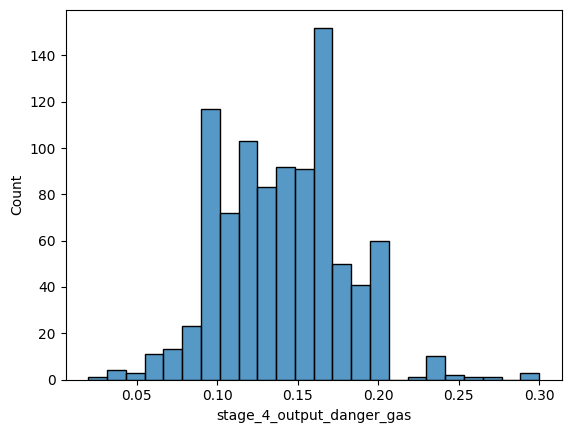

In [33]:
sns.histplot(df['stage_4_output_danger_gas'])

#Поиск лучшей модели, комбинации факторов и оценок метрик R2 и MAPE

Определяем лучшую модель из инициализированныз на основе метрики R2. Выводим метрики R2 и MAPE моделей с лучшей комбинацией факторов.

Данный алгоритм занимает большое количество времени.

In [34]:
for model_name in regression_models:
    list_of_factors = []
    print(f"Показатели модели {model_name}: ")
    model = regression_models[model_name]
    best_factors_by_sbs(model, df, list_of_factors)

Показатели модели SVR: 
Лучшая пара метрик: R2 = -0.0820, MAPE = 0.2832
Метрики оценены на основе следующих факторов: ['stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_temp', 'stage_2_output_top_vacuum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_output_temp_hum_steam', 'stage_4_input_overheated_steam', 'stage_4_output_dry_residue_avg', 'work_shift']
=-----------------------------------------------
Показатели модели Decision Tree Regressor: 
Лучшая пара метрик: R2 = 0.1197, MAPE = 0.2185
Метрики оценены на основе следующих факторов: ['DateTime']
=-----------------------------------------------
Показатели модели Gradient Boosting Regressor: 
Лучшая пара метрик: R2 = 0.3321, MAPE = 0.1981
Метрики оценены на основе следующих факторов: ['DateTime', 'stage_1_output_konv_avd', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_tem

#Выводы:

##Оценка метрик: **R2 = 0.3909, MAPE = 0.1905**. Модель Random Forest Regressor.

###**Неудовлетворительная прогностическая способность модели**: Проведенный анализ показал, что среди протестированных моделей наилучшие результаты достигнуты с помощью Random Forest Regressor (RFR), однако даже эта модель не продемонстрировала удовлетворительной прогностической способности в отношении доли опасного газа. Остальные модели, включая SVR, Decision Tree Regressor, Gradient Boosting Regressor, K-Nearest Neighbors Regressor (с n_neighbors = 5 и 3), показали худшие результаты. Несмотря на то, что RFR показал лучшие метрики (R2 = 0.3909 и MAPE = 0.1905), они по-прежнему свидетельствуют о том, что модель объясняет лишь небольшую долю дисперсии целевой переменной, а предсказания имеют значительные отклонения от фактических значений. Таким образом, RFR является лучшим выбором из рассмотренных моделей, но его прогностическая сила остается недостаточной.


###**Недопустимость замены ручных замеров на основе текущей модели**: Принимая во внимание низкие показатели прогностической точности модели и существенную величину погрешности предсказаний, её использование в качестве замены ручных замеров доли опасного газа является недопустимым. Ошибки в предсказаниях, достигающие в среднем 19%, могут иметь критические последствия, особенно в контексте мониторинга потенциально опасных веществ. Таким образом, текущая модель не обеспечивает требуемой надежности и точности для принятия ответственных решений.